# Import libraries

In [1]:
# !pip install arch
# !pip install yfinance
# !pip install pandas_datareader
# !pip install tensorflow

import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from time import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
#from pandas.plotting import scatter_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.regularizers import l1_l2

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import numpy as np
from pandas.core.common import random_state
from sklearn.model_selection import train_test_split
import itertools
# import tensorflow as tf
# from keras.regularizers import l1_l2
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras import regularizers


# Download Data

### CCAR Variables

In [2]:
# Time period
end = '2023-04-30'
start = '1982-1-1'

# FRED, Bloomberg, Yahoo Finance Data
Y_ticker = ["^VIX"]
X_ticker1 = ["SPY","GC=F","DX-Y.NYB"]
Fred_data1 = ["GDP","GDPC1","A067RL1Q156SBEA","A067RP1Q027SBEA","UNRATE","CPIAUCSL","TB3MS","GS5","GS10","MPRIME","BOGZ1FL075035243Q","BOGZ1FL075035503Q"]
Fred_data2 = ["MORTGAGE30US"]
#X1 = yf.download(Y_ticker, start=start, end=end, progress = False,group_by="ticker")
X2 = web.DataReader(Fred_data1,'fred',start,end)
Y = yf.download(Y_ticker, start=start, end=end, progress = False,group_by="ticker")
Y = pd.DataFrame(Y['Adj Close'])
X3 = web.DataReader(Fred_data2,'fred','1981-12-01','2023-04-30')
Dow_jones = web.DataReader('BOGZ1FL073164013Q','fred',start,end)
Y_SPX = yf.download('^SPX',start=start, end=end, progress = False,group_by="ticker")
Y_SPX = pd.DataFrame(Y_SPX['Adj Close'])


### Additional Variables

In [3]:
# FRED, Bloomberg, Yahoo Finance Data
Fred_data3 = ["UMCSENT","DFF","PPIACO","M1SL","M2SL","ICSA","STLFSI4","BAMLC0A4CBBB"]

#X1 = yf.download(Y_ticker, start=start, end=end, progress = False,group_by="ticker")
X2_add = web.DataReader(Fred_data3,'fred',start,end)
dollar= yf.download('DX-Y.NYB', start=start, end=end, progress = False,group_by="ticker")
dollar = pd.DataFrame(dollar['Adj Close'])

### Define Column names

In [4]:
# Define column names
col_name1={'GDP':'Nom GDP', 'GDPC1':'Real GDP','A067RL1Q156SBEA':'Real Disp Income','A067RP1Q027SBEA':'Nom Disp Income','UNRATE':'Unemp Rate','CPIAUCSL':'CPI','TB3MS':'3m TSY','GS5':'5Y TSY','GS10':'10Y TSY','MPRIME':'Prime Rate', 'BOGZ1FL075035243Q': 'HPI', 'BOGZ1FL075035503Q': 'Commercial REI'}
col_name2 = {'MORTGAGE30US':'Mortgage Rate'}
dj_col = {'BOGZ1FL073164013Q':'Dow Jones Total'}
Y_col = {'Adj Close':'VIX'}
spx = {'Adj Close':'SPX'}

# Additional variables column names
col_names_add = {'UMCSENT':'MCSI', 'DFF': 'Effective Federal Fund Rate', 'PPIACO': 'PPI', 'M1SL': 'M1','M2SL':'M2','ICSA': 'ICSA','STLFSI4': 'Federal Stress Index','BAMLC0A4CBBB': 'OAS BBB Corp'}
dollar_col = {'Adj Close': 'Dollar'}

# Data Cleaning and Preprocessing

### Renaming columns

In [5]:
# Function to rename columns
def rename_columns(S,column_name):
    S = S.rename(columns=column_name)
    return S

In [6]:
# Rename columns by replacing ticker names with actual variable names
fred_1 = rename_columns(X2,col_name1)
fred_2 = rename_columns(X3,col_name2)
Dow_jones_qtr = rename_columns(Dow_jones,dj_col)
Y = rename_columns(Y,Y_col)
dollar = rename_columns(dollar,dollar_col)

# Additonal variables data
fred_3 = rename_columns(X2_add,col_names_add)
Y_SPX1 = rename_columns(Y_SPX,spx)

In [7]:
# Function to convert datetime to date only
def date_time(S):
    S.index = S.index.date
    S.index = pd.to_datetime(S.index)
    return S

In [8]:
# Changing datetime variables to date only variables
dollar_index = date_time(dollar)
Y_index = date_time(Y)
Y_SPX2 = date_time(Y_SPX1)

# Max value of VIX and Last value of Dollar Index
VIX_monthly = Y_index.resample('M').max()
dollar_monthly = dollar_index.resample('M').last()
SPX_monthly = Y_SPX2.resample('M').last()
SPX_monthly_pct = SPX_monthly.pct_change()*100

### Extracting Data from initial dataframe

In [9]:
# Extract each variable from dataframe and store in Dataframe
real_gdp_qtr = pd.DataFrame(fred_1['Real GDP'])
nom_gdp_qtr = pd.DataFrame(fred_1['Nom GDP'])
nom_disp_inc_qtr = pd.DataFrame(fred_1['Nom Disp Income'])
real_disp_inc_qtr = pd.DataFrame(fred_1['Real Disp Income'])
unemp_rate_monthly = pd.DataFrame(fred_1['Unemp Rate']).resample('M').max()
CPI_monthly = pd.DataFrame(fred_1['CPI'])
tsy_3m_monthly = pd.DataFrame(fred_1['3m TSY']).resample('M').max()
tsy_5y_monthly = pd.DataFrame(fred_1['5Y TSY']).resample('M').max()
tsy_10y_monthly = pd.DataFrame(fred_1['10Y TSY']).resample('M').max()
prime_rate_monthly = pd.DataFrame(fred_1['Prime Rate']).resample('M').max()
HPI_qtr = pd.DataFrame(fred_1['HPI'])
REI_qtr = pd.DataFrame(fred_1['Commercial REI'])

### Data Cleaning

In [10]:
# Function to calculate growth rate and convert to month
def growth_calc_to_monthly(S,n):
    growth1 = pd.DataFrame(S.dropna())
    growth2 = (((1+ growth1.pct_change())**4)-1)*100
    growth2.index = growth2.index.shift(3,freq='MS')
    growth2 = (growth2.asfreq('MS',method='ffill')/n).resample('M').max()
    return growth2

In [11]:
# Function to convert weekly to monthly data (One period forward shift)
def weekly_to_monthly(S):
    monthly = S.resample('M').mean()
    monthly.index = monthly.index.shift(1,freq='M')
    return monthly

In [12]:
# Function to convert quarterly to monthly (Forwardfill)
def quarterly_to_monthly_forwardfill(S,n):
    monthly = pd.DataFrame(S.dropna())
    monthly.index = monthly.index.shift(3,freq='MS')
    monthly = (monthly.asfreq('MS',method='ffill')/n).resample('M').max()
    return monthly

In [13]:
# Convert weekly data to monthly data
mortgage_monthly = weekly_to_monthly(fred_2)

# Convert quarterly data to monthly data
nom_disp_inc_monthly = quarterly_to_monthly_forwardfill(nom_disp_inc_qtr,3)
real_disp_inc_monthly = quarterly_to_monthly_forwardfill(real_disp_inc_qtr,3)
nom_gdp_monthly_growth = growth_calc_to_monthly(nom_gdp_qtr,3)
real_gdp_monthly_growth = growth_calc_to_monthly(real_gdp_qtr,3)
HPI_monthly = quarterly_to_monthly_forwardfill(HPI_qtr,1000)
REI_monthly = quarterly_to_monthly_forwardfill(REI_qtr,1000)
Dow_jones_monthly = quarterly_to_monthly_forwardfill(Dow_jones_qtr,1000)


# Taking percentage of indices
CPI_monthly_pct = pd.DataFrame(fred_1['CPI'].pct_change()*100).resample('M').max()
Dow_jones_qtr_pct = Dow_jones_qtr.pct_change()*100
Dow_jones_qtr_pct = Dow_jones_qtr_pct.dropna()
Dow_jones_qtr_pct_1 = quarterly_to_monthly_forwardfill(Dow_jones_qtr_pct,3)
HPI_qtr_pct = HPI_qtr.dropna()
#HPI_qtr_pct1 = HPI_qtr_pct.pct_change()*100
HPI_qtr_pct2 = quarterly_to_monthly_forwardfill(HPI_qtr_pct.pct_change()*100,3)
REI_qtr_pct = REI_qtr.dropna()
#REI_qtr_pct1 = REI_qtr_pct.pct_change()*100
REI_qtr_pct2 = quarterly_to_monthly_forwardfill(REI_qtr_pct.pct_change()*100,3)

### Combining to DataFrame - CCAR data

In [14]:
# Combining into single dataframe
cols = [real_gdp_monthly_growth,nom_gdp_monthly_growth,real_disp_inc_monthly,nom_disp_inc_monthly,unemp_rate_monthly,CPI_monthly_pct,tsy_3m_monthly,tsy_5y_monthly,tsy_10y_monthly,mortgage_monthly,prime_rate_monthly,Dow_jones_qtr_pct_1,HPI_qtr_pct2,REI_qtr_pct2]
combined_data_1 = pd.concat(cols,axis = 1)
combined_data_2 = combined_data_1.drop(combined_data_1.index[:3])
ccar_new = combined_data_2.drop(combined_data_1.index[-2:])
missing_value_column_1 = ['Dow Jones Total', 'HPI', 'Commercial REI']
ccardata_comb = pd.concat([ccar_new,VIX_monthly],axis=1)
ccardata_comb = ccardata_comb.dropna()
ccardata_comb.head(10)


,Real GDP,Nom GDP,Real Disp Income,Nom Disp Income,Unemp Rate,CPI,3m TSY,5Y TSY,10Y TSY,Mortgage Rate,Prime Rate,Dow Jones Total,HPI,Commercial REI,VIX
1990-01-31,0.263512,1.231059,1.133333,2.233333,5.4,0.950119,7.64,8.12,8.21,9.7440,10.11,-0.065953,0.476171,0.122040,27.250000
1990-02-28,0.263512,1.231059,1.133333,2.233333,5.3,0.392157,7.74,8.42,8.47,9.8950,10.00,-0.065953,0.476171,0.122040,24.870001
1990-03-31,0.263512,1.231059,1.133333,2.233333,5.2,0.468750,7.90,8.60,8.59,10.1975,10.00,-0.065953,0.476171,0.122040,22.740000
1990-04-30,1.481119,3.007416,1.033333,3.066667,5.4,0.233281,7.77,8.77,8.79,10.2680,10.00,-1.427146,0.365090,-0.294387,24.160000
1990-05-31,1.481119,3.007416,1.033333,3.066667,5.4,0.155159,7.74,8.74,8.76,10.3700,10.00,-1.427146,0.365090,-0.294387,20.139999
1990-06-30,1.481119,3.007416,1.033333,3.066667,5.2,0.619675,7.73,8.43,8.48,10.4775,10.00,-1.427146,0.365090,-0.294387,19.360001
1990-07-31,0.486523,2.027329,0.933333,2.200000,5.5,0.461894,7.62,8.33,8.47,10.1640,10.00,1.536702,0.082595,-0.294550,23.680000
1990-08-31,0.486523,2.027329,0.933333,2.200000,5.7,0.842912,7.45,8.44,8.75,10.0350,10.00,1.536702,0.082595,-0.294550,36.470001
1990-09-30,0.486523,2.027329,0.933333,2.200000,5.9,0.683891,7.36,8.51,8.89,10.1000,10.00,1.536702,0.082595,-0.294550,30.559999
1990-10-31,0.088772,1.249580,-0.033333,1.666667,5.9,0.679245,7.17,8.33,8.72,10.1750,10.00,-5.305404,-0.097730,-0.137110,33.980000


### Additional Variable Cleaning

In [15]:
fred_add_var = fred_3.resample('M').mean()
a = fred_3['Effective Federal Fund Rate'].resample('M').last()
b = fred_3['MCSI'].resample('M').last()
c = fred_3['PPI'].resample('M').last()
d = fred_3['M1'].resample('M').last()
e = fred_3['M2'].resample('M').last()
f = fred_3['ICSA'].resample('M').sum()
g = fred_3['OAS BBB Corp'].resample('M').last().dropna()
new_cols = [a,b,c,d,e,f,g,dollar_monthly,SPX_monthly_pct,VIX_monthly]
add_var = pd.concat(new_cols,axis=1)

# ls = ['MCSI', 'Effective Federal Fund Rate', 'PPI', 'M1','M2','ICSA','Federal Stress Index','OAS BBB Corp']

# fred_add_var['PPI'] = fred_add_var['PPI'].pct_change()
add_var

,Effective Federal Fund Rate,MCSI,PPI,M1,M2,ICSA,OAS BBB Corp,Dollar,SPX,VIX
1982-01-31,14.21,71.0,99.700,442.7,1770.4,2676000.0,NaN,108.029999,NaN,NaN
1982-02-28,13.74,66.5,99.800,441.9,1774.5,2135000.0,NaN,111.930000,-6.054818,NaN
1982-03-31,16.80,62.0,99.600,442.7,1786.5,2226000.0,NaN,114.730003,-1.016711,NaN
1982-04-30,15.28,65.5,99.600,447.1,1803.9,2348000.0,NaN,111.599998,4.001432,NaN
1982-05-31,13.38,67.5,99.800,446.7,1815.4,2919000.0,NaN,112.790001,-3.916184,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-12-31,4.33,59.7,257.897,19821.0,21358.1,1053000.0,1.72,103.519997,-5.897147,25.000000
2023-01-31,4.33,64.9,260.227,19560.2,21212.7,798000.0,1.56,102.099998,6.175286,22.900000
2023-02-28,4.57,67.0,258.672,19328.2,21077.4,874000.0,1.60,104.870003,-2.611249,22.870001
2023-03-31,4.83,62.0,257.071,18965.3,20841.1,968000.0,1.77,102.510002,3.505161,26.520000


In [16]:
ccardata_monthly_features = add_var.dropna()
ccardata_monthly_features.head(10)

,Effective Federal Fund Rate,MCSI,PPI,M1,M2,ICSA,OAS BBB Corp,Dollar,SPX,VIX
1996-12-31,6.26,96.9,129.1,1081.3,3818.6,1414000.0,0.83,88.180000,-2.150541,21.990000
1997-01-31,5.37,97.4,129.7,1081.2,3834.6,1356000.0,0.82,93.040001,6.131704,21.139999
1997-02-28,5.50,99.7,128.5,1078.8,3846.3,1283000.0,0.79,94.889999,0.592759,21.410000
1997-03-31,7.07,100.0,127.3,1072.5,3861.2,1597000.0,0.76,94.720001,-4.261401,22.139999
1997-04-30,5.82,101.4,127.0,1063.9,3877.0,1308000.0,0.79,97.180000,5.840558,21.340000
1997-05-31,5.58,103.2,127.4,1063.8,3889.2,1619000.0,0.79,94.849998,5.857688,21.570000
1997-06-30,6.87,104.5,127.2,1066.1,3906.0,1302000.0,0.76,95.669998,4.345261,21.820000
1997-07-31,5.96,107.1,126.9,1065.5,3923.9,1281000.0,0.74,99.639999,7.814581,23.510000
1997-08-31,5.52,104.4,127.2,1075.3,3957.4,1651000.0,0.74,99.000000,-5.746563,24.760000
1997-09-30,5.81,106.0,127.5,1066.9,3973.1,1261000.0,0.75,97.110001,5.315359,25.990000


In [17]:
lst = [ccardata_monthly_features['Effective Federal Fund Rate'].diff(),ccardata_monthly_features['MCSI'].pct_change()*100,
        ccardata_monthly_features['PPI'].pct_change()*100,ccardata_monthly_features['M1'].pct_change()*100,
        ccardata_monthly_features['M2'].pct_change()*100,ccardata_monthly_features['ICSA'].pct_change()*100,
        ccardata_monthly_features['Dollar'].pct_change()*100]

In [18]:
ccardata_sp=pd.concat([ccardata_monthly_features['Effective Federal Fund Rate'].diff(),ccardata_monthly_features['MCSI'].pct_change()*100,
        ccardata_monthly_features['PPI'].pct_change()*100,ccardata_monthly_features['M1'].pct_change()*100,
        ccardata_monthly_features['M2'].pct_change()*100,ccardata_monthly_features['ICSA'].pct_change()*100,
        ccardata_monthly_features['Dollar'].pct_change()*100,g,SPX_monthly_pct,VIX_monthly],axis=1)
ccardata_spx = ccardata_sp.dropna()
ccardata_spx

,Effective Federal Fund Rate,MCSI,PPI,M1,M2,ICSA,Dollar,OAS BBB Corp,SPX,VIX
1997-01-31,-0.89,0.515996,0.464756,-0.009248,0.419002,-4.101839,5.511455,0.82,6.131704,21.139999
1997-02-28,0.13,2.361396,-0.925212,-0.221976,0.305117,-5.383481,1.988390,0.79,0.592759,21.410000
1997-03-31,1.57,0.300903,-0.933852,-0.583982,0.387385,24.473889,-0.179153,0.76,-4.261401,22.139999
1997-04-30,-1.25,1.400000,-0.235664,-0.801865,0.409199,-18.096431,2.597127,0.79,5.840558,21.340000
1997-05-31,-0.24,1.775148,0.314961,-0.009399,0.314676,23.776758,-2.397615,0.79,5.857688,21.570000
...,...,...,...,...,...,...,...,...,...,...
2022-12-31,0.50,5.105634,-1.998807,-0.719273,-0.191130,23.882353,-2.293535,1.72,-5.897147,25.000000
2023-01-31,0.00,8.710218,0.903461,-1.315776,-0.680772,-24.216524,-1.371714,1.56,6.175286,22.900000
2023-02-28,0.24,3.235747,-0.597555,-1.186082,-0.637825,9.523810,2.713031,1.60,-2.611249,22.870001
2023-03-31,0.26,-7.462687,-0.618931,-1.877567,-1.121106,10.755149,-2.250406,1.77,3.505161,26.520000


<AxesSubplot:>

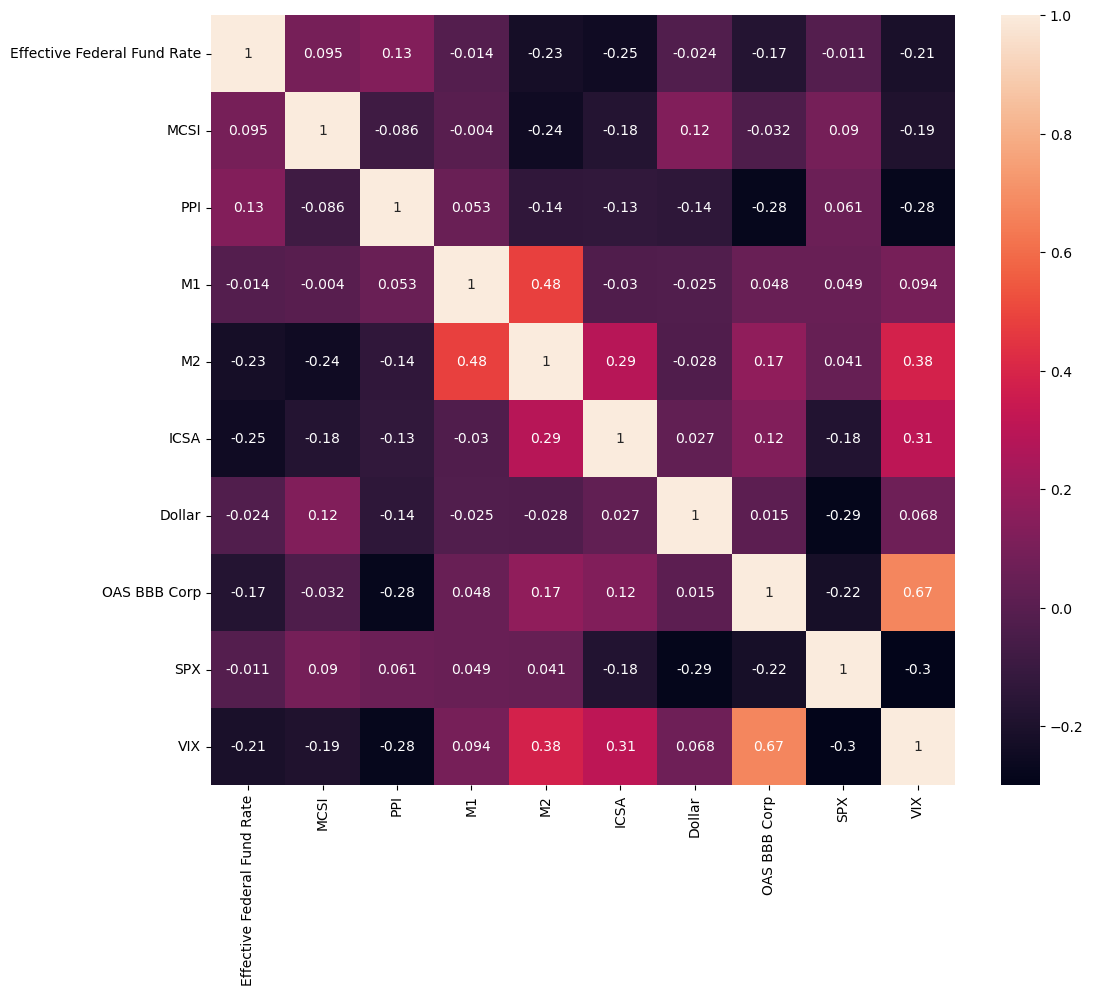

In [19]:
plt.figure(figsize=(12, 10))
sns.heatmap(ccardata_spx.corr(),annot=True)

# TIME SERIES

In [20]:
import pandas as pd
import statsmodels.api as sm

def seasonality_trend_residual(S, model_type):
    ccardata_seasonal = pd.DataFrame(index=S.index, columns=S.columns)
    ccardata_trend = pd.DataFrame(index=S.index, columns=S.columns)
    ccardata_residual = pd.DataFrame(index=S.index, columns=S.columns)
    ccardata_SA = pd.DataFrame(index=S.index, columns=S.columns)
    
    for column in S.columns:
        seasonal_decomposition = sm.tsa.seasonal_decompose(S[column], model=model_type)
        deseasonalized = S[column] - seasonal_decomposition.seasonal
        #detrend = S[column] - seasonal_decomposition.trend
        #residual = S[column] - seasonal_decomposition.resid
        
        ccardata_SA.loc[:, column] = deseasonalized
        ccardata_seasonal.loc[:, column] = seasonal_decomposition.seasonal
        ccardata_trend.loc[:, column] = seasonal_decomposition.trend
        ccardata_residual.loc[:, column] = seasonal_decomposition.resid
        

        
    return ccardata_seasonal, ccardata_trend, ccardata_residual,ccardata_SA

In [21]:
# Data with Dow Jones
ccardata_seasonal,ccardata_trend,ccardata_residual,ccardata_SA = seasonality_trend_residual(ccardata_monthly_features,'additive')
ccardata_trend = ccardata_trend.dropna()
ccardata_residual = ccardata_residual.dropna()

In [22]:
# Data with SPX
ccardata_spx_seasonal,ccardata_spx_trend,ccardata_spx_residual,ccardata_spx_SA = seasonality_trend_residual(ccardata_spx,'additive')
ccardata_spx_trend = ccardata_spx_trend.dropna()
ccardata_spx_residual = ccardata_spx_residual.dropna()

## ARIMAX

In [23]:
# Function for finding out ARIMAX pdq order and RMSE
def ARIMAX_pdq_order(p_range, d_range, q_range, train_x, test_x, train_y, test_y):
    p_values = range(0, p_range)
    d_values = range(0, d_range)
    q_values = range(0, q_range)

    # Initialize variables
    best_rmse = float('inf')
    best_order = None

    # Generate all combinations of p, d, q values
    order_combinations = list(itertools.product(p_values, d_values, q_values))

    for order in order_combinations:
        try:
            # Create and fit the ARIMAX model
            model = sm.tsa.ARIMA(train_y, order=order, exog=train_x)
            results = model.fit()
            forecast_ARIMAX = results.forecast(steps=len(test_y), exog=test_x)
            rmse = np.sqrt(mean_squared_error(test_y, forecast_ARIMAX))

            # Check if current RMSE is better than the previous best
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order

        except:
            continue

    # Print the best order values and RMSE
    return "Best Order:", best_order, "Best RMSE:", best_rmse

In [24]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def ARIMAX_order_table(train_x, test_x, train_y, test_y, order):
    # Create and fit the ARIMAX model
    model = sm.tsa.ARIMA(train_y, exog=train_x, order=order)
    results = model.fit()
    forecast_ARIMAX = results.forecast(steps=len(test_y), exog=test_x)
    rmse = np.sqrt(mean_squared_error(test_y, forecast_ARIMAX))
    mape = np.mean(np.abs((test_y - forecast_ARIMAX) / test_y)) * 100
    mae = mean_absolute_error(test_y, forecast_ARIMAX)
    r_squared = r2_score(test_y, forecast_ARIMAX)
    aic = results.aic
    bic = results.bic

    # Create a DataFrame to store the results
    results_df = pd.DataFrame([[order, rmse, mape, mae, r_squared,aic, bic]],
                              columns=["Order", "RMSE", "MAPE", "MAE", "R-Squared","AIC", "BIC"])

    # Print the results in tabular form
    return results_df

In [25]:
z = ccardata_monthly_features.columns
train_X, test_X, train_Y,test_Y = train_test_split(ccardata_monthly_features.iloc[:,0:len(z)-1],ccardata_monthly_features.iloc[:,-1],test_size=0.20,shuffle=False)

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
# # All 7 features
# ARIMAX_NSA = ARIMAX_pdq_order(4,4,4,train_X, test_X, train_Y,test_Y)
# ARIMAX_NSA

In [28]:
# Dow Jones removed and SPX added
train_x_spx, test_x_spx, train_y_spx,test_y_spx = train_test_split(ccardata_spx.iloc[:,0:len(ccardata_spx.columns)-1],ccardata_spx.iloc[:,-1],test_size=0.20,shuffle=False)

ARIMAX_spx = ARIMAX_pdq_order(4,4,4,train_x_spx, test_x_spx, train_y_spx,test_y_spx)
ARIMAX_spx

('Best Order:', (2, 0, 0), 'Best RMSE:', 8.572705299589952)

In [29]:
# SPX Seasonally Adjusted
train_x_spx_SA, test_x_spx_SA, train_y_spx_SA,test_y_spx_SA = train_test_split(ccardata_spx_SA.iloc[:,0:len(ccardata_spx_SA.columns)-1],ccardata_spx_SA.iloc[:,-1],test_size=0.20,shuffle=False)

ARIMAX_spx_SA = ARIMAX_pdq_order(4,4,4,train_x_spx_SA, test_x_spx_SA, train_y_spx_SA,test_y_spx_SA)
ARIMAX_spx_SA

('Best Order:', (2, 0, 0), 'Best RMSE:', 8.051439250651718)

### Modelling ARIMAX

In [30]:
# Function inputs - (p_range,d_range,q_range,train_x,test_x,train_y,test_y)
def ARIMAX_model_in(train_x,test_x,train_y,test_y,order):
    model_ARIMAX = sm.tsa.ARIMA(train_y, order=order, exog=train_x)
    results_ARIMAX = model_ARIMAX.fit()
    forecast_ARIMAX = results_ARIMAX.forecast(steps=len(test_y), exog=test_x)
    predict = results_ARIMAX.predict(start = '1997-01-31', end ='2017-12-31')
    rmse = np.sqrt(mean_squared_error(predict,train_y))
    return rmse,predict

In [31]:
# Function inputs - (p_range,d_range,q_range,train_x,test_x,train_y,test_y)
def ARIMAX_model_out(train_x,test_x,train_y,test_y,order):
    model_ARIMAX = sm.tsa.ARIMA(train_y, order=order, exog=train_x)
    results_ARIMAX = model_ARIMAX.fit()
    forecast_ARIMAX = results_ARIMAX.forecast(steps=len(test_y), exog=test_x)
    rmse = np.sqrt(mean_squared_error(forecast_ARIMAX,test_y))
    return rmse,forecast_ARIMAX

In [32]:
# Stationary NSA (With SPX)
rmse_insample_ARIMAX_spx_NSA, forecast_ARIMAX_insample_spx_NSA = ARIMAX_model_in(train_x_spx, test_x_spx, train_y_spx,test_y_spx,ARIMAX_spx[1])
rmse_outsample_ARIMAX_spx_NSA, forecast_ARIMAX_outsample_spx_NSA = ARIMAX_model_out(train_x_spx, test_x_spx, train_y_spx,test_y_spx,ARIMAX_spx[1])
print('ARIMAX Not Seasonally Adjusted')
print('In sample RMSE:',rmse_insample_ARIMAX_spx_NSA)
print('Out sample RMSE:',rmse_outsample_ARIMAX_spx_NSA)

ARIMAX Not Seasonally Adjusted
In sample RMSE: 4.218075171253452
Out sample RMSE: 8.572705299589952


In [33]:
# Stationary SA (With SPX)
rmse_insample_ARIMAX_spx_SA, forecast_ARIMAX_insample_spx_SA = ARIMAX_model_in(train_x_spx_SA, test_x_spx_SA, train_y_spx_SA,test_y_spx_SA,ARIMAX_spx_SA[1])
rmse_outsample_ARIMAX_spx_SA, forecast_ARIMAX_outsample_spx_SA = ARIMAX_model_out(train_x_spx_SA, test_x_spx_SA, train_y_spx_SA,test_y_spx_SA,ARIMAX_spx_SA[1])
print('ARIMAX Not Seasonally Adjusted')
print('In sample RMSE:',rmse_insample_ARIMAX_spx_SA)
print('Out sample RMSE:',rmse_outsample_ARIMAX_spx_SA)

ARIMAX Not Seasonally Adjusted
In sample RMSE: 4.102406922114376
Out sample RMSE: 8.051439250651718


### ARIMAX Plots

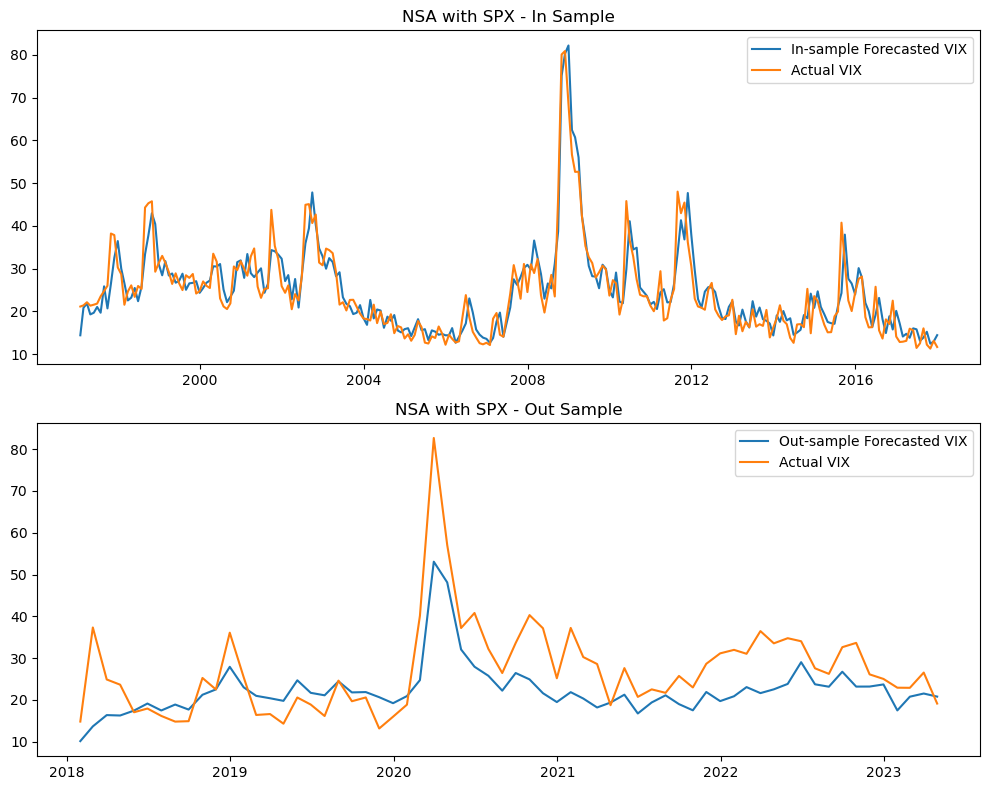

In [34]:
# Create subplots with two rows and one column
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# First subplot - Stationary NSA
axs[0].plot(forecast_ARIMAX_insample_spx_NSA, label='In-sample Forecasted VIX')
axs[0].plot(train_y_spx, label='Actual VIX')
axs[0].set_title('NSA with SPX - In Sample')
axs[0].legend()

# Second subplot - Stationary SA
axs[1].plot(forecast_ARIMAX_outsample_spx_NSA, label='Out-sample Forecasted VIX')
axs[1].plot(test_y_spx, label='Actual VIX')
axs[1].set_title('NSA with SPX - Out Sample')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


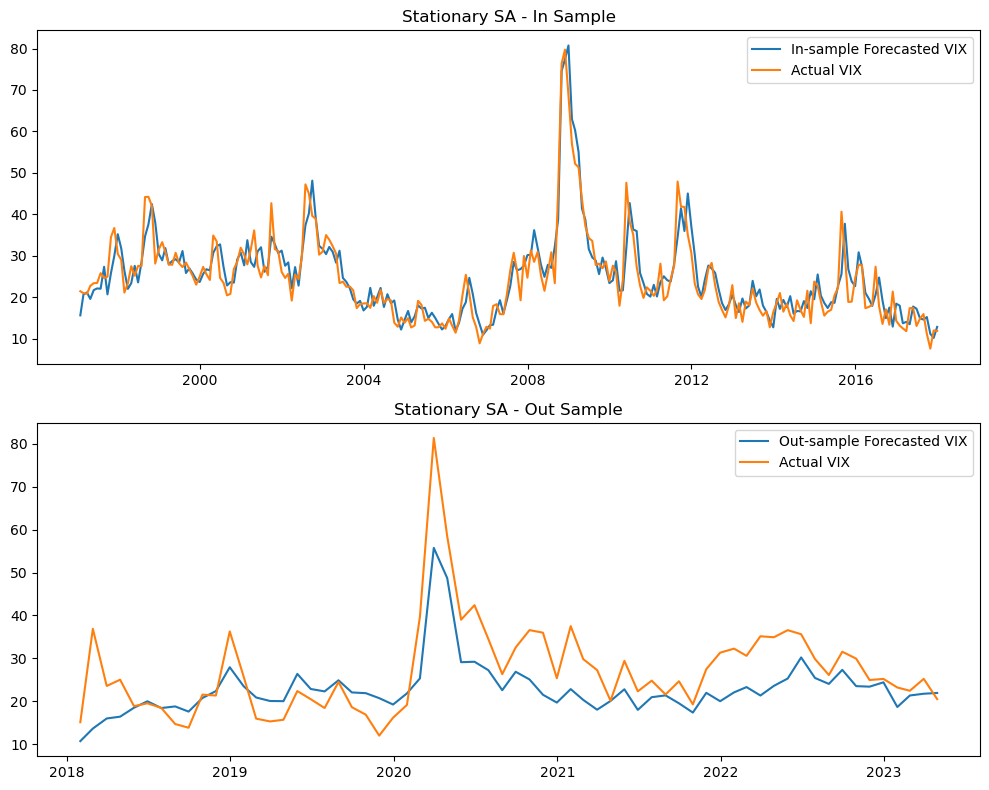

In [35]:
# Create subplots with two rows and one column
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# First subplot - Stationary NSA
axs[0].plot(forecast_ARIMAX_insample_spx_SA, label='In-sample Forecasted VIX')
axs[0].plot(train_y_spx_SA, label='Actual VIX')
axs[0].set_title('Stationary SA - In Sample')
axs[0].legend()

# Second subplot - Stationary SA
axs[1].plot(forecast_ARIMAX_outsample_spx_SA, label='Out-sample Forecasted VIX')
axs[1].plot(test_y_spx_SA, label='Actual VIX')
axs[1].set_title('Stationary SA - Out Sample')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [36]:
pd.concat([
          ARIMAX_order_table(train_x_spx, test_x_spx, train_y_spx,test_y_spx,ARIMAX_spx[1]).rename(index={0: 'ARIMAX SPX NSA'}),
          ARIMAX_order_table( train_x_spx_SA, test_x_spx_SA, train_y_spx_SA,test_y_spx_SA,ARIMAX_spx_SA[1]).rename(index={0: 'ARIMAX SPX SA'})], axis=0)


,Order,RMSE,MAPE,MAE,R-Squared,AIC,BIC
ARIMAX SPX NSA,"(2, 0, 0)",8.572705,22.562422,6.573230,0.386103,1466.043581,1511.926159
ARIMAX SPX SA,"(2, 0, 0)",8.051439,21.529937,6.180232,0.451269,1452.476595,1498.359174


## ARIMAX - With selected features

#### Splits
1. ccardata_monthly_features = train_X, test_X, train_Y,test_Y   (NSA)            --- ARIMAX_NSA
2. ccardata_seasonal = X_train, X_test, Y_train,Y_test                            --- ARIMAX_Seasonal
3. ccardata_trend = X_TRAIN, X_TEST, Y_TRAIN,Y_TEST                               --- ARIMAX_Trend
4. ccardata_residual = TRAIN_X, TEST_X, TRAIN_Y,TEST_Y                            --- ARIMAX_Resid
5. ccardata_SA = X_TRAIN_SA, X_TEST_SA, Y_TRAIN_SA,Y_TEST_SA                      --- ARIMAX_SA
6. ccardata_spx = train_x_spx, test_x_spx, train_y_spx,test_y_spx   (NSA)         --- ARIMAX_spx
7. ccadata_spx_SA = train_x_spx_SA, test_x_spx_SA, train_y_spx_SA,test_y_spx_SA   --- ARIMAX_spx_SA

In [37]:
# import itertools
# import statsmodels.api as sm
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Function for finding out ARIMAX pdq order and RMSE
# def ARIMAX_pdq_order(p_range, d_range, q_range, train_x, test_x, train_y, test_y):
#     p_values = range(0, p_range)
#     d_values = range(0, d_range)
#     q_values = range(0, q_range)

#     # Initialize variables
#     best_rmse = float('inf')
#     best_order = None
#     best_features = None

#     # Generate all combinations of p, d, q values
#     order_combinations = list(itertools.product(p_values, d_values, q_values))

#     for order in order_combinations:
#         for r in range(1, len(special_features) + 1):
#             # Generate all combinations of r special features
#             feature_combinations = list(itertools.combinations(special_features, r))
#             for features in feature_combinations:
#                 try:
#                     # Create and fit the ARIMAX model
#                     model = sm.tsa.ARIMA(train_y, order=order, exog=train_x[list(features)])
#                     results = model.fit()
#                     forecast_ARIMAX = results.forecast(steps=len(test_y), exog=test_x[list(features)])
#                     rmse = np.sqrt(mean_squared_error(test_y, forecast_ARIMAX))

#                     # Check if current RMSE is better than the previous best
#                     if rmse < best_rmse:
#                         best_rmse = rmse
#                         best_order = order
#                         best_features = features

#                 except:
#                     continue

#     # Print the best order values, best features, and RMSE
#     return "Best Order:", best_order, "Best Features:", best_features, "Best RMSE:", best_rmse


# result = ARIMAX_pdq_order(4, 4, 4, train_x_spx_SA[special_features], test_x_spx_SA[special_features], train_y_spx_SA, test_y_spx_SA)
# print(result)


In [38]:
train_x_spx_SA.columns

Index(['Effective Federal Fund Rate', 'MCSI', 'PPI', 'M1', 'M2', 'ICSA',
       'Dollar', 'OAS BBB Corp', 'SPX'],
      dtype='object')

In [39]:
special_features = ['M2', 'PPI', 'MCSI', 'ICSA', 'OAS BBB Corp', 'SPX']

In [40]:
test_ARIMAX_spx_SA = ARIMAX_pdq_order(4,4,4,train_x_spx_SA[special_features], test_x_spx_SA[special_features], train_y_spx_SA,test_y_spx_SA)
test_ARIMAX_spx_SA

('Best Order:', (2, 0, 2), 'Best RMSE:', 7.36211652035792)

In [41]:
test_ARIMAX_spx_NSA = ARIMAX_pdq_order(4,4,4,train_x_spx[special_features], test_x_spx[special_features], train_y_spx,test_y_spx)
test_ARIMAX_spx_NSA

('Best Order:', (2, 0, 0), 'Best RMSE:', 7.669337247721938)

In [42]:
# Stationary SA (With SPX)
test_rmse_insample_ARIMAX_spx_SA, test_forecast_ARIMAX_insample_spx_SA = ARIMAX_model_in(train_x_spx_SA[special_features], test_x_spx_SA[special_features], train_y_spx_SA,test_y_spx_SA,test_ARIMAX_spx_SA[1])
test_rmse_outsample_ARIMAX_spx_SA, test_forecast_ARIMAX_outsample_spx_SA = ARIMAX_model_out(train_x_spx_SA[special_features], test_x_spx_SA[special_features], train_y_spx_SA,test_y_spx_SA,test_ARIMAX_spx_SA[1])
print('ARIMAX Not Seasonally Adjusted')
print('In sample RMSE:',test_rmse_insample_ARIMAX_spx_SA)
print('Out sample RMSE:',test_rmse_outsample_ARIMAX_spx_SA)

ARIMAX Not Seasonally Adjusted
In sample RMSE: 4.090730285232147
Out sample RMSE: 7.36211652035792


In [43]:
ARIMAX_order_table(train_x_spx_SA[special_features], test_x_spx_SA[special_features], train_y_spx_SA,test_y_spx_SA,test_ARIMAX_spx_SA[1]).rename(index={0: 'ARIMAX SA'})

,Order,RMSE,MAPE,MAE,R-Squared,AIC,BIC
ARIMAX SA,"(2, 0, 2)",7.362117,19.028095,5.447909,0.541206,1449.954064,1492.307213


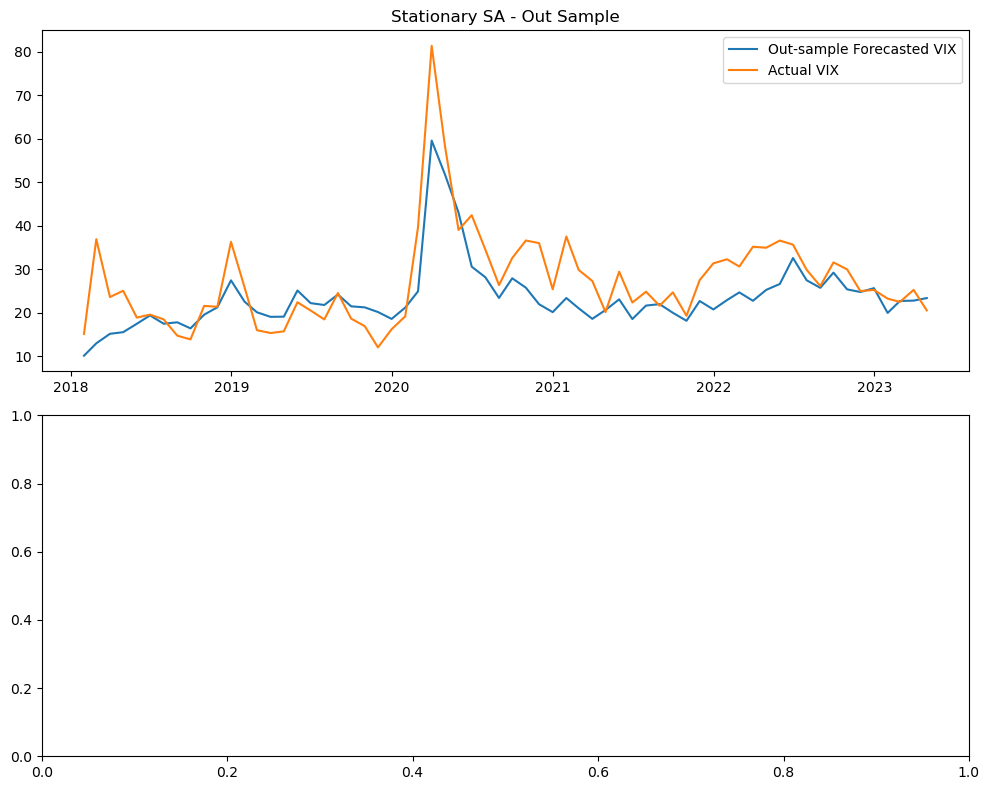

In [44]:
# Create subplots with two rows and one column
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Second subplot - Stationary SA
axs[0].plot(test_forecast_ARIMAX_outsample_spx_SA, label='Out-sample Forecasted VIX')
axs[0].plot(test_y_spx_SA, label='Actual VIX')
axs[0].set_title('Stationary SA - Out Sample')
axs[0].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

# Combination of All Features

In [45]:
special_features = ['M2', 'PPI', 'MCSI', 'ICSA', 'OAS BBB Corp', 'SPX','VIX']

In [46]:
original_features = ['Unemp Rate','CPI', '3m TSY', '5Y TSY', '10Y TSY', 'Mortgage Rate']
combined_feature_data = pd.concat([ccardata_comb[original_features],ccardata_spx[special_features]],axis=1).dropna()

In [47]:
combined_feature_data.head()

,Unemp Rate,CPI,3m TSY,5Y TSY,10Y TSY,Mortgage Rate,M2,PPI,MCSI,ICSA,OAS BBB Corp,SPX,VIX
1997-01-31,5.3,0.188561,5.03,6.33,6.58,7.5975,0.419002,0.464756,0.515996,-4.101839,0.82,6.131704,21.139999
1997-02-28,5.2,0.188206,5.01,6.20,6.42,7.8240,0.305117,-0.925212,2.361396,-5.383481,0.79,0.592759,21.410000
1997-03-31,5.2,0.062617,5.14,6.54,6.69,7.6500,0.387385,-0.933852,0.300903,24.473889,0.76,-4.261401,22.139999
1997-04-30,5.1,0.062578,5.16,6.76,6.89,7.8975,0.409199,-0.235664,1.400000,-18.096431,0.79,5.840558,21.340000
1997-05-31,4.9,0.000000,5.05,6.57,6.71,8.1425,0.314676,0.314961,1.775148,23.776758,0.79,5.857688,21.570000


In [48]:
# Data with SPX
combined_seasonal,combined_trend,combined_residual,combined_SA = seasonality_trend_residual(combined_feature_data,'additive')
combined_trend = combined_trend.dropna()
combined_residual = combined_residual.dropna()

In [49]:
# SPX Seasonally Adjusted
train_x_combined_SA, test_x_combined_SA, train_y_combined_SA,test_y_combined_SA = train_test_split(combined_SA.iloc[:,0:len(combined_SA.columns)-1],combined_SA.iloc[:,-1],test_size=0.20,shuffle=False)

ARIMAX_combined_SA = ARIMAX_pdq_order(4,4,4,train_x_combined_SA, test_x_combined_SA, train_y_combined_SA,test_y_combined_SA)
ARIMAX_combined_SA

('Best Order:', (0, 2, 0), 'Best RMSE:', 11.336614872547216)

### BEST FEATURES

In [50]:
train_x_combined_SA.columns

Index(['Unemp Rate', 'CPI', '3m TSY', '5Y TSY', '10Y TSY', 'Mortgage Rate',
       'M2', 'PPI', 'MCSI', 'ICSA', 'OAS BBB Corp', 'SPX'],
      dtype='object')

In [51]:
latest_features = ['5Y TSY','10Y TSY', 'M2', 'PPI', 'MCSI', 'ICSA', 'OAS BBB Corp', 'SPX']

In [52]:
# SPX Seasonally Adjusted
trainx_combined_SA, testx_combined_SA, trainy_combined_SA,testy_combined_SA = train_test_split(combined_SA.iloc[:,0:len(combined_SA.columns)-1],combined_SA.iloc[:,-1],test_size=0.20,shuffle=False)

ARIMAXcombined_SA = ARIMAX_pdq_order(5,5,5,trainx_combined_SA[latest_features], testx_combined_SA[latest_features], trainy_combined_SA,testy_combined_SA)
ARIMAXcombined_SA

('Best Order:', (1, 3, 3), 'Best RMSE:', 6.901155154911296)

In [53]:
# Stationary SA (With SPX)
test_rmseinsample_ARIMAX_spx_SA, test_forecastARIMAX_insample_spx_SA = ARIMAX_model_in(trainx_combined_SA[latest_features], testx_combined_SA[latest_features], trainy_combined_SA,testy_combined_SA,ARIMAXcombined_SA[1])
test_rmseoutsample_ARIMAX_spx_SA, test_forecastARIMAX_outsample_spx_SA = ARIMAX_model_out(trainx_combined_SA[latest_features], testx_combined_SA[latest_features], trainy_combined_SA,testy_combined_SA,ARIMAXcombined_SA[1])
print('ARIMAX Not Seasonally Adjusted')
print('In sample RMSE:',test_rmseinsample_ARIMAX_spx_SA)
print('Out sample RMSE:',test_rmseoutsample_ARIMAX_spx_SA)

ARIMAX Not Seasonally Adjusted
In sample RMSE: 4.497937347282081
Out sample RMSE: 6.901155154911296


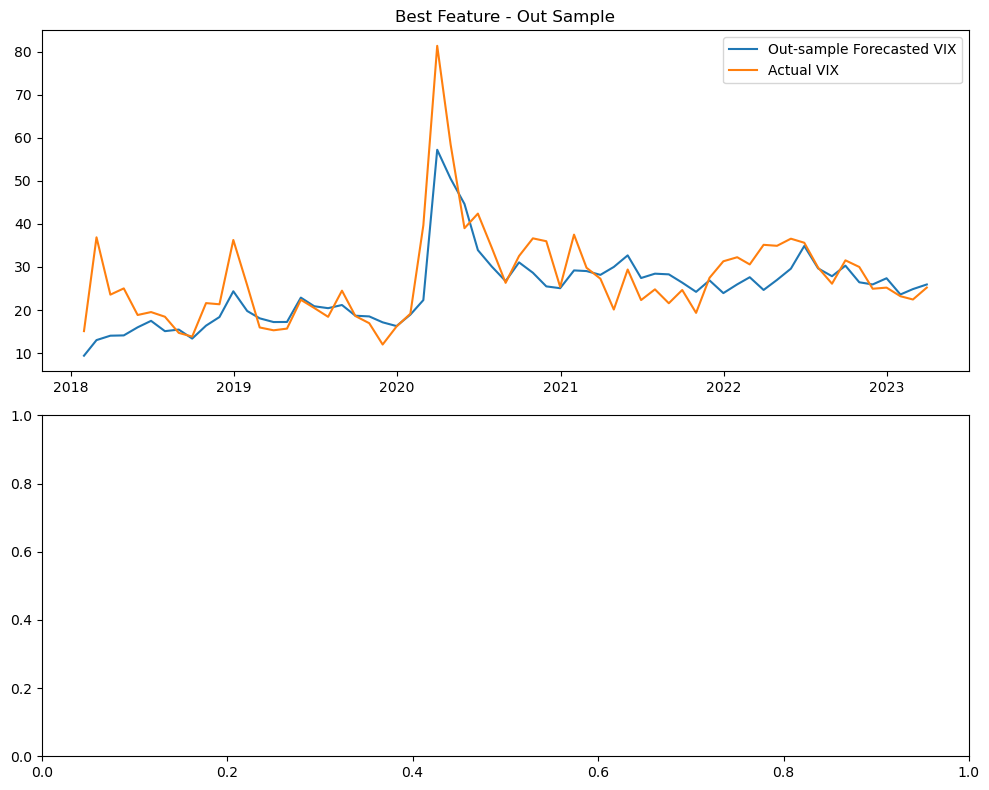

In [54]:
# Create subplots with two rows and one column
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Second subplot - Stationary SA
axs[0].plot(test_forecastARIMAX_outsample_spx_SA, label='Out-sample Forecasted VIX')
axs[0].plot(testy_combined_SA, label='Actual VIX')
axs[0].set_title('Best Feature - Out Sample')
axs[0].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [55]:
ARIMAX_order_table(trainx_combined_SA[latest_features], testx_combined_SA[latest_features], trainy_combined_SA,testy_combined_SA,ARIMAXcombined_SA[1]).rename(index={0: 'ARIMAX SA'})

,Order,RMSE,MAPE,MAE,R-Squared,AIC,BIC
ARIMAX SA,"(1, 3, 3)",6.901155,16.089747,4.686889,0.600696,1481.190497,1526.917385


#### Checking direction accuracy

In [56]:
import pandas as pd

# Function to determine the direction of a dataset
def get_direction(data):
    direction = []
    for i in range(1, len(data)):
        if data.iloc[i, 0] > data.iloc[i-1, 0]:
            direction.append(1)  # Increasing
        elif data.iloc[i, 0] < data.iloc[i-1, 0]:
            direction.append(-1)  # Decreasing
        else:
            direction.append(0)  # No change
    return direction

# Determine directions of y_test and y_pred
y_test_direction = get_direction(pd.DataFrame(testy_combined_SA))
y_pred_direction = get_direction(pd.DataFrame(test_forecastARIMAX_outsample_spx_SA))

# Compare the directions and count the number of matching cases
matching_count = sum(1 for i in range(len(y_test_direction)) if y_test_direction[i] == y_pred_direction[i])

# Print the results
print("y_test directions:", y_test_direction)
print("y_pred directions:", y_pred_direction)
print("Number of matching cases:", matching_count)


y_test directions: [1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 1]
y_pred directions: [1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1]
Number of matching cases: 47


In [57]:
47/63

0.746031746031746

In [58]:
# import itertools
# import statsmodels.api as sm
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Function for finding out ARIMAX pdq order and RMSE
# def ARIMAX_pdq_order11(p_range, d_range, q_range, train_x, test_x, train_y, test_y):
#     p_values = range(0, p_range)
#     d_values = range(0, d_range)
#     q_values = range(0, q_range)

#     # Initialize variables
#     best_rmse = float('inf')
#     best_order = None
#     best_features = None

#     # Generate all combinations of p, d, q values
#     order_combinations = list(itertools.product(p_values, d_values, q_values))

#     for order in order_combinations:
#         for r in range(1, len(latest_features) + 1):
#             # Generate all combinations of r special features
#             feature_combinations = list(itertools.combinations(latest_features, r))
#             for features in feature_combinations:
#                 try:
#                     # Create and fit the ARIMAX model
#                     model = sm.tsa.ARIMA(train_y, order=order, exog=train_x[list(features)])
#                     results = model.fit()
#                     forecast_ARIMAX = results.forecast(steps=len(test_y), exog=test_x[list(features)])
#                     rmse = np.sqrt(mean_squared_error(test_y, forecast_ARIMAX))

#                     # Check if current RMSE is better than the previous best
#                     if rmse < best_rmse:
#                         best_rmse = rmse
#                         best_order = order
#                         best_features = features

#                 except:
#                     continue

#     # Print the best order values, best features, and RMSE
#     return "Best Order:", best_order, "Best Features:", best_features, "Best RMSE:", best_rmse


# result12 = ARIMAX_pdq_order11(4, 4, 4, train_x_combined_SA[latest_features], test_x_combined_SA[latest_features], train_y_combined_SA,test_y_combined_SA)
# print(result12)


In [59]:
# # Stationary NSA (With SPX)
# rmse_insample_ARIMAX_spx_NSA, forecast_ARIMAX_insample_spx_NSA = ARIMAX_model_in(train_x_spx, test_x_spx, train_y_spx,test_y_spx,ARIMAX_spx[1])
# rmse_outsample_ARIMAX_spx_NSA, forecast_ARIMAX_outsample_spx_NSA = ARIMAX_model_out(train_x_spx, test_x_spx, train_y_spx,test_y_spx,ARIMAX_spx[1])
# print('ARIMAX Not Seasonally Adjusted')
# print('In sample RMSE:',rmse_insample_ARIMAX_spx_NSA)
# print('Out sample RMSE:',rmse_outsample_ARIMAX_spx_NSA)

# ARIMAX-GARCH

#### Dataset to be used
1. trainx_combined_SA[latest_features], testx_combined_SA[latest_features], trainy_combined_SA,testy_combined_SA

### ARIMAX-GARCH Order calculation

In [60]:
import itertools
import arch
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error

def find_best_arimax_garch_order(trainx_combined_SA, testx_combined_SA, trainy_combined_SA,testy_combined_SA):
    p_values = range(1, 4)
    d_values = range(0, 4)
    q_values = range(1, 4)
    pdq = list(itertools.product(p_values, d_values, q_values))

    P_values = range(1, 4)
    Q_values = range(1, 4)
    pq = list(itertools.product(P_values, Q_values))

    best_rmse = float('inf')
    best_arima_order = None
    best_garch_order = None

    for arima_order in pdq:
        for garch_order in pq:
            # Create and fit the ARIMAX model
            model = sm.tsa.ARIMA(trainy_combined_SA, order=arima_order, exog=trainx_combined_SA[latest_features])
            arima_results = model.fit()
            arima_residuals = arima_results.resid
            arima_pred = arima_results.forecast(steps=len(testy_combined_SA), exog=testx_combined_SA[latest_features])

            garch_model = arch.arch_model(arima_residuals, vol='Garch', p=garch_order[0], q=garch_order[1])
            results = garch_model.fit()
            garch_pred = results.forecast(horizon=len(testy_combined_SA))
            a = np.sqrt(garch_pred.variance.iloc[-1, :])
            a.index = testy_combined_SA.index
            a_mean = a.mean()
            total = a_mean + arima_pred
            rmse = np.sqrt(mean_squared_error(testy_combined_SA, total))

            if rmse < best_rmse:
                best_rmse = rmse
                best_arima_order = arima_order
                best_garch_order = garch_order

    return best_arima_order, best_garch_order

In [61]:
# Usage example
best_arima_order, best_garch_order = find_best_arimax_garch_order(trainx_combined_SA[latest_features], testx_combined_SA[latest_features], trainy_combined_SA,testy_combined_SA)
print("Best ARIMAX Order:", best_arima_order)
print("Best GARCH Order:", best_garch_order)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 732.8525737942763
Iteration:      2,   Func. Count:     13,   Neg. LLF: 728.8841923852665
Iteration:      3,   Func. Count:     20,   Neg. LLF: 707.0258286442986
Iteration:      4,   Func. Count:     26,   Neg. LLF: 707.0818652668719
Iteration:      5,   Func. Count:     32,   Neg. LLF: 707.0197619565236
Iteration:      6,   Func. Count:     37,   Neg. LLF: 707.0183888652346
Iteration:      7,   Func. Count:     42,   Neg. LLF: 707.017046135618
Iteration:      8,   Func. Count:     47,   Neg. LLF: 707.0170425699705
Iteration:      9,   Func. Count:     51,   Neg. LLF: 707.0170425699398
Optimization terminated successfully    (Exit mode 0)
            Current function value: 707.0170425699705
            Iterations: 9
            Function evaluations: 51
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      7,   Neg. LLF: 712.2282041316207
Iteration:      2,   Func. Count:     15,   Neg. LLF: 708.075282008924
Ite

In [63]:
# # Function for finding out ARIMAX pdq order and RMSE
# import arch

# p_values = range(1, 4)
# d_values = range(0, 4)
# q_values = range(1, 4)
# pdq = list(itertools.product(p_values,d_values,q_values))

# P_values = range(1, 4)
# Q_values = range(1, 4)

# pq = list(itertools.product(P_values,Q_values))

# best_rmse = float('inf')
# best_arima_order = None
# best_garch_order = None


# for arima_order in pdq:
# for garch_order in pq:
# # Create and fit the ARIMAX model
# model = sm.tsa.ARIMA(trainy_combined_SA, order=arima_order,exog = trainx_combined_SA[latest_features])
# arima_results = model.fit()
# arima_residuals = arima_results.resid
# arima_pred = arima_results.forecast(steps = len(testy_combined_SA),exog = testx_combined_SA[latest_features])

# garch_model = arch.arch_model(arima_residuals, vol = 'Garch', p = garch_order[0], q = garch_order[1])
# results = garch_model.fit()
# garch_pred = results.forecast(horizon = len(testy_combined_SA))
# a = np.sqrt(garch_pred.variance.iloc[-1,:])
# a.index = testy_combined_SA.index
# a_mean = a.mean()
# total = a_mean + arima_pred
# rmse = np.sqrt(mean_squared_error(testy_combined_SA, total))
# if rmse < best_rmse:
# best_rmse = rmse
# best_arima_order = arima_order
# best_garch_order = garch_order

In [64]:
import numpy as np
import pandas as pd
import arch
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def arimax_garch_analysis(trainx_combined_SA, testx_combined_SA, trainy_combined_SA,testy_combined_SA):
    # Fit ARIMAX model
    model_arimax = sm.tsa.ARIMA(trainy_combined_SA, order=(2,3,3), exog=trainx_combined_SA[latest_features])
    arimax_results = model_arimax.fit()
    arimax_residuals = arimax_results.resid
    
    # Perform GARCH modeling
    garch_model = arch.arch_model(arimax_residuals, vol='Garch', p=1, q=3)
    garch_results = garch_model.fit()
    
    # Generate ARIMAX-GARCH predictions
    arimax_pred = arimax_results.forecast(steps=len(testy_combined_SA), exog=testx_combined_SA[latest_features])
    garch_pred = garch_results.forecast(horizon=len(testy_combined_SA))
    a = np.sqrt(garch_pred.variance.iloc[-1, :])
    a.index = testy_combined_SA.index
    a_mean = a.mean()
    total = arimax_pred + a_mean
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(testy_combined_SA, total))
    mape = np.mean(np.abs((testy_combined_SA - total) / testy_combined_SA)) * 100
    mae = mean_absolute_error(testy_combined_SA, total)
    r_squared = r2_score(testy_combined_SA, total)
    aic = arimax_results.aic + garch_results.aic
    bic = arimax_results.bic + garch_results.bic
    
    # Create output table
    output_table = pd.DataFrame({
        'ARIMAX-GARCH Order': [f'ARIMA{(2,3,3)}-GARCH({(1)}, {(3)})'],
        'RMSE': [rmse],
        'MAPE': [mape],
        'MAE': [mae],
        'R-squared': [r_squared],
        'AIC': [aic],
        'BIC': [bic]
    })
    
    return output_table

### ARIMAX-GARCH Modeling with best features

In [99]:
import arch
model1 = sm.tsa.ARIMA(trainy_combined_SA, order=(2,3,3),exog = trainx_combined_SA[latest_features])
arima_results = model1.fit()
arima_residuals = arima_results.resid
arima_pred = arima_results.forecast(steps = len(testy_combined_SA),exog = testx_combined_SA[latest_features])

garch_model = arch.arch_model(arima_residuals, vol = 'Garch', p = 1, q = 3)
results = garch_model.fit()
garch_pred = results.forecast(horizon = len(testy_combined_SA))
a = np.sqrt(garch_pred.variance.iloc[-1,:])
a.index = testy_combined_SA.index
a_mean = a.mean() 
total = arima_pred +a_mean

Iteration:      1,   Func. Count:      8,   Neg. LLF: 2158.020010177891
Iteration:      2,   Func. Count:     18,   Neg. LLF: 927.8877110520349
Iteration:      3,   Func. Count:     27,   Neg. LLF: 742.563471413054
Iteration:      4,   Func. Count:     35,   Neg. LLF: 728.5420427712949
Iteration:      5,   Func. Count:     43,   Neg. LLF: 728.1952990782896
Iteration:      6,   Func. Count:     50,   Neg. LLF: 728.185252181742
Iteration:      7,   Func. Count:     57,   Neg. LLF: 728.1875381373015
Iteration:      8,   Func. Count:     65,   Neg. LLF: 728.1712895442586
Iteration:      9,   Func. Count:     72,   Neg. LLF: 728.1702901908225
Iteration:     10,   Func. Count:     79,   Neg. LLF: 728.1701542044684
Iteration:     11,   Func. Count:     86,   Neg. LLF: 728.1701536230328
Optimization terminated successfully    (Exit mode 0)
            Current function value: 728.1701536230328
            Iterations: 11
            Function evaluations: 86
            Gradient evaluations: 11


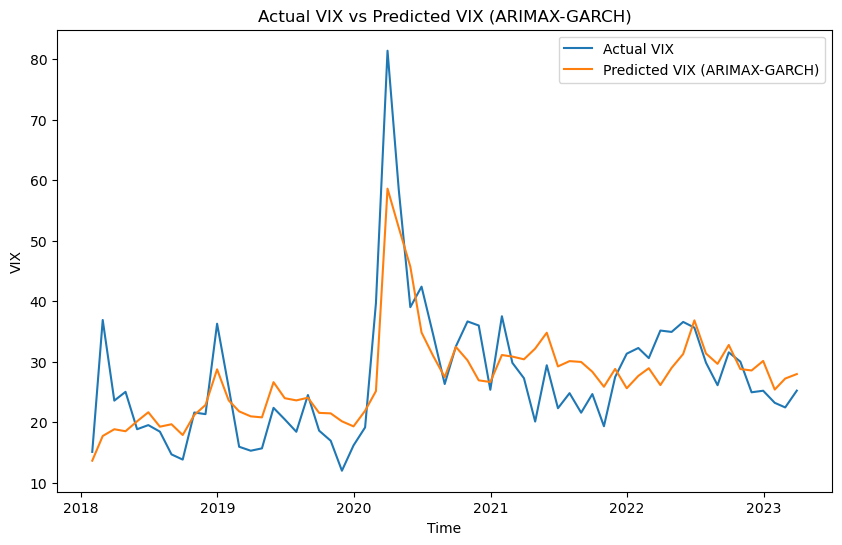

In [66]:
import matplotlib.pyplot as plt

# Plotting the variables
plt.figure(figsize=(10, 6))
plt.plot(testy_combined_SA, label='Actual VIX')
plt.plot(total, label='Predicted VIX (ARIMAX-GARCH)')
plt.xlabel('Time')
plt.ylabel('VIX')
plt.title('Actual VIX vs Predicted VIX (ARIMAX-GARCH)')
plt.legend()
plt.show()

In [67]:
arimax_garch_analysis(trainx_combined_SA[latest_features], testx_combined_SA[latest_features], trainy_combined_SA,testy_combined_SA).rename(index={0: 'ARIMAX SA'})

Iteration:      1,   Func. Count:      8,   Neg. LLF: 2158.020010177891
Iteration:      2,   Func. Count:     18,   Neg. LLF: 927.8877110520349
Iteration:      3,   Func. Count:     27,   Neg. LLF: 742.563471413054
Iteration:      4,   Func. Count:     35,   Neg. LLF: 728.5420427712949
Iteration:      5,   Func. Count:     43,   Neg. LLF: 728.1952990782896
Iteration:      6,   Func. Count:     50,   Neg. LLF: 728.185252181742
Iteration:      7,   Func. Count:     57,   Neg. LLF: 728.1875381373015
Iteration:      8,   Func. Count:     65,   Neg. LLF: 728.1712895442586
Iteration:      9,   Func. Count:     72,   Neg. LLF: 728.1702901908225
Iteration:     10,   Func. Count:     79,   Neg. LLF: 728.1701542044684
Iteration:     11,   Func. Count:     86,   Neg. LLF: 728.1701536230328
Optimization terminated successfully    (Exit mode 0)
            Current function value: 728.1701536230328
            Iterations: 11
            Function evaluations: 86
            Gradient evaluations: 11


,ARIMAX-GARCH Order,RMSE,MAPE,MAE,R-squared,AIC,BIC
ARIMAX SA,"ARIMA(2, 3, 3)-GARCH(1, 3)",6.35534,18.682352,4.874073,0.661361,2944.235124,3014.656039


#### Checking direction accuracy

In [68]:
# Determine directions of y_test and y_pred
y_test_direction1 = get_direction(pd.DataFrame(testy_combined_SA))
y_pred_direction1 = get_direction(pd.DataFrame(total))

# Compare the directions and count the number of matching cases
matching_count1 = sum(1 for i in range(len(y_test_direction1)) if y_test_direction1[i] == y_pred_direction1[i])

# Print the results
print("y_test directions:", y_test_direction1)
print("y_pred directions:", y_pred_direction1)
print("Number of matching cases:", matching_count1)

y_test directions: [1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 1]
y_pred directions: [1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1]
Number of matching cases: 45


In [69]:
45/63

0.7142857142857143

## ARIMAX-GARCH Prediction Interval

In [71]:
from scipy.stats import norm

Iteration:      1,   Func. Count:      8,   Neg. LLF: 2158.020010177891
Iteration:      2,   Func. Count:     18,   Neg. LLF: 927.8877110520349
Iteration:      3,   Func. Count:     27,   Neg. LLF: 742.563471413054
Iteration:      4,   Func. Count:     35,   Neg. LLF: 728.5420427712949
Iteration:      5,   Func. Count:     43,   Neg. LLF: 728.1952990782896
Iteration:      6,   Func. Count:     50,   Neg. LLF: 728.185252181742
Iteration:      7,   Func. Count:     57,   Neg. LLF: 728.1875381373015
Iteration:      8,   Func. Count:     65,   Neg. LLF: 728.1712895442586
Iteration:      9,   Func. Count:     72,   Neg. LLF: 728.1702901908225
Iteration:     10,   Func. Count:     79,   Neg. LLF: 728.1701542044684
Iteration:     11,   Func. Count:     86,   Neg. LLF: 728.1701536230328
Optimization terminated successfully    (Exit mode 0)
            Current function value: 728.1701536230328
            Iterations: 11
            Function evaluations: 86
            Gradient evaluations: 11


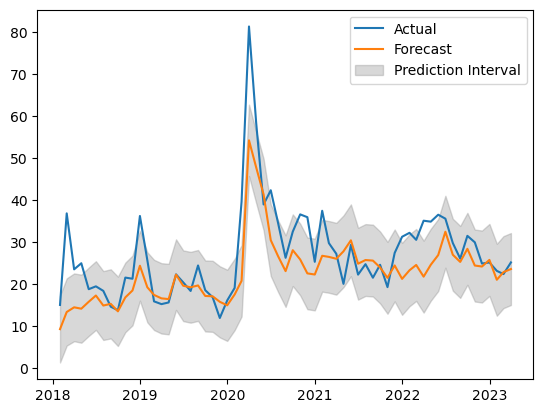

In [72]:
import arch
model11 = sm.tsa.ARIMA(trainy_combined_SA, order=(2,3,3),exog = trainx_combined_SA[latest_features])
arimax_results = model11.fit()
arimax_residuals = arimax_results.resid
arimax_pred = arimax_results.forecast(steps = len(testy_combined_SA),exog = testx_combined_SA[latest_features])

garch_model1 = arch.arch_model(arimax_residuals, vol = 'Garch', p = 1, q = 3)
results11 = garch_model1.fit()
garch_pred11 = results11.forecast(horizon = len(testy_combined_SA))
ad = np.sqrt(garch_pred11.variance.iloc[-1,:])
ad.index = testy_combined_SA.index
#ad_mean = ad.mean() 
total_interval = arimax_pred

confidence_level = 0.95  # Change as desired
z_value = norm.ppf(1 - (1 - confidence_level) / 2)
total_interval_upper = arimax_pred + (z_value * ad)
total_interval_lower = arimax_pred - (z_value * ad)

# Plotting
plt.plot(testy_combined_SA, label='Actual')
plt.plot(total_interval, label='Forecast')
plt.fill_between(testy_combined_SA.index, total_interval_lower, total_interval_upper, color='gray', alpha=0.3, label='Prediction Interval')
#plt.plot(total_interval_upper, label='Upper', color='y')
#plt.plot(total_interval_lower, label='Lower', color='b')
plt.legend()
plt.show()

# SARIMAX

In [73]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def SARIMAX_order_table(train_x, test_x, train_y, test_y, order, seasonal_order):
    # Create and fit the SARIMAX model
    model = sm.tsa.SARIMAX(train_y, exog=train_x, order=order, seasonal_order=seasonal_order)
    results = model.fit()
    forecast_SARIMAX = results.forecast(steps=len(test_y), exog=test_x)
    rmse = np.sqrt(mean_squared_error(test_y, forecast_SARIMAX))
    mape = np.mean(np.abs((test_y - forecast_SARIMAX) / test_y)) * 100
    mae = mean_absolute_error(test_y, forecast_SARIMAX)
    r_squared = r2_score(test_y, forecast_SARIMAX)
    aic = results.aic
    bic = results.bic

    # Create a DataFrame to store the results
    results_df = pd.DataFrame([[order, seasonal_order, rmse, mape, mae, r_squared, aic, bic]],
                              columns=["Order", "Seasonal Order", "RMSE", "MAPE", "MAE", "R-squared", "AIC", "BIC"])

    # Print the results in tabular form
    return results_df

In [74]:
import itertools

def SARIMAX_order(X_train, X_test, Y_train,Y_test,s):
    p_values = range(1, 3)
    d_values = range(0, 3)
    q_values = range(1, 3)
    pdq = list(itertools.product(p_values, d_values, q_values))

    P_values = range(1, 3)
    D_values = range(0, 3)
    Q_values = range(1, 3)
    S_values = s
    pdqs = list(itertools.product(P_values, D_values, Q_values, S_values))

    best_rmse = float('inf')
    best_order = None
    best_seasonal_order = None

    for i in range(len(pdq)):
        for j in range(len(pdqs)):
            # Create and fit the SARIMAX model
            model = sm.tsa.SARIMAX(Y_train, order=pdq[i], seasonal_order=pdqs[j], exog=X_train)
            results = model.fit()
            forecast_SARIMAX = results.forecast(steps=len(Y_test), exog=X_test)
            rmse = np.sqrt(mean_squared_error(Y_test, forecast_SARIMAX))
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = pdq[i]
                best_seasonal_order = pdqs[j]

    print(f"Order: {best_order}, Seasonal Order: {best_seasonal_order}, RMSE: {best_rmse}")

In [75]:
def SARIMAX_order1():
    p_values = range(1, 3)
    d_values = range(0, 3)
    q_values = range(1, 3)
    pdq = list(itertools.product(p_values, d_values, q_values))

    P_values = range(1, 3)
    D_values = range(0, 3)
    Q_values = range(1, 3)
    S_values = [6, 12]
    pdqs = list(itertools.product(P_values, D_values, Q_values, S_values))

    best_rmse = float('inf')
    best_order = None
    best_seasonal_order = None

    for i in range(len(pdq)):
        for j in range(len(pdqs)):
            # Create and fit the SARIMAX model
            model = sm.tsa.SARIMAX(Y_train, order=pdq[i], seasonal_order=pdqs[j], exog=X_train)
            results = model.fit()
            forecast_SARIMAX = results.forecast(steps=len(Y_test), exog=X_test)
            rmse = np.sqrt(mean_squared_error(test_y, forecast_SARIMAX))
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = pdq[i]
                best_seasonal_order = pdqs[j]

        print(f"Order: {best_order}, Seasonal Order: {best_seasonal_order}, RMSE: {best_rmse}")

In [76]:
from sklearn.metrics import mean_squared_error, r2_score
def SARIMAX_model_in(train_x, test_x, train_y, test_y, order, seasonal_order):
    model_SARIMAX = sm.tsa.SARIMAX(train_y, exog=train_x, order=order, seasonal_order=seasonal_order)
    results_SARIMAX = model_SARIMAX.fit()
    forecast_SARIMAX = results_SARIMAX.forecast(steps=len(test_y), exog=test_x)
    predict = results_SARIMAX.predict(start='1990-01-31', end='2016-07-31')
    rmse = np.sqrt(mean_squared_error(predict, train_y))
    r_squared = r2_score(train_y, predict)
    return rmse, predict,r_squared

In [77]:
def SARIMAX_model_out(train_x, test_x, train_y, test_y, order, seasonal_order):
    model_SARIMAX = sm.tsa.SARIMAX(train_y, exog=train_x, order=order, seasonal_order=seasonal_order)
    results_SARIMAX = model_SARIMAX.fit()
    forecast_SARIMAX = results_SARIMAX.forecast(steps=len(test_y), exog=test_x)
    rmse = np.sqrt(mean_squared_error(forecast_SARIMAX, test_y))
    r_squared = r2_score(test_y, forecast_SARIMAX)
    return rmse, forecast_SARIMAX,r_squared

In [78]:
sarimax_features = ['5Y TSY','10Y TSY', 'M2', 'PPI', 'MCSI', 'ICSA', 'OAS BBB Corp', 'SPX','VIX']

In [79]:
sarimax_data_NSA = combined_feature_data[sarimax_features]

In [80]:
# SPX Seasonally Adjusted
train_x_sarimax_NSA, test_x_sarimax_NSA, train_y_sarimax_NSA,test_y_sarimax_NSA = train_test_split(sarimax_data_NSA.iloc[:,0:len(sarimax_data_NSA.columns)-1],sarimax_data_NSA.iloc[:,-1],test_size=0.20,shuffle=False)

In [81]:
SARIMAX_order(train_x_sarimax_NSA, test_x_sarimax_NSA, train_y_sarimax_NSA,test_y_sarimax_NSA,[12])

Order: (1, 2, 1), Seasonal Order: (1, 2, 2, 12), RMSE: 7.965727110528698


In [82]:
def SARIMAX_model_out(train_x, test_x, train_y, test_y, order, seasonal_order):
    model_SARIMAX = sm.tsa.SARIMAX(train_y, exog=train_x, order=order, seasonal_order=seasonal_order)
    results_SARIMAX = model_SARIMAX.fit()
    forecast_SARIMAX = results_SARIMAX.forecast(steps=len(test_y), exog=test_x)
    rmse = np.sqrt(mean_squared_error(forecast_SARIMAX, test_y))
    r_squared = r2_score(test_y, forecast_SARIMAX)
    return rmse, forecast_SARIMAX,r_squared

In [87]:
# SARIMAX
rmse_outsample_SARIMAX_selected, forecast_SARIMAX_outsample_selected,R_squared_out = SARIMAX_model_out(train_x_sarimax_NSA, test_x_sarimax_NSA, train_y_sarimax_NSA,test_y_sarimax_NSA,(1,2,1),(1,2,2,12))
print('SARIMAX Not Seasonally Adjusted')
print('Out sample RMSE:',rmse_outsample_SARIMAX_selected)
print('R-squared:',R_squared_out)

SARIMAX Not Seasonally Adjusted
Out sample RMSE: 7.965727110528698
R-squared: 0.4737025252738215


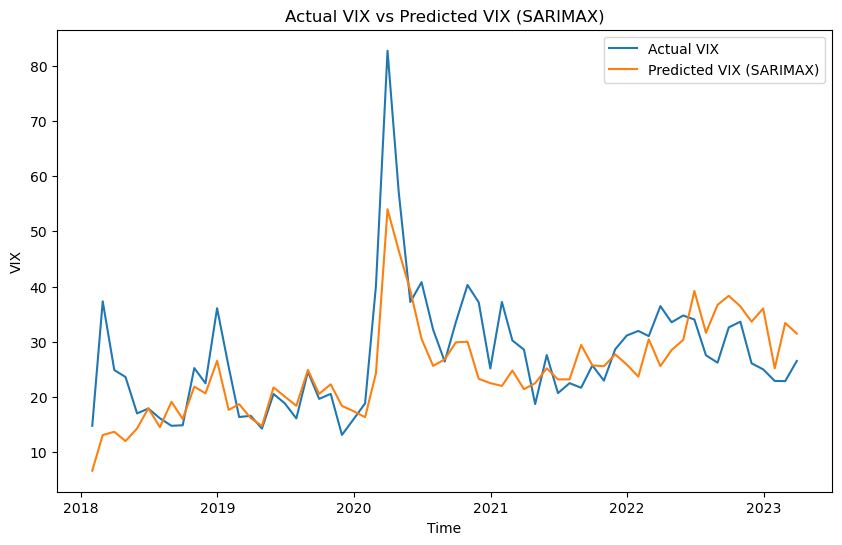

In [86]:
import matplotlib.pyplot as plt

# Plotting the variables
plt.figure(figsize=(10, 6))
plt.plot(test_y_sarimax_NSA, label='Actual VIX')
plt.plot(forecast_SARIMAX_outsample_selected, label='Predicted VIX (SARIMAX)')
plt.xlabel('Time')
plt.ylabel('VIX')
plt.title('Actual VIX vs Predicted VIX (SARIMAX)')
plt.legend()
plt.show()

# LSTM

In [ ]:
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import mean_squared_error

# # Dummy data for illustration
# train_x_latest = trainx_combined_SA[latest_features]
# train_y_latest = trainy_combined_SA
# test_x_latest = testx_combined_SA[latest_features]
# test_y_latest = testy_combined_SA

# # Apply StandardScaler to normalize the training and testing data
# scaler = StandardScaler()
# train_x_scaled = scaler.fit_transform(train_x_latest)
# test_x_scaled = scaler.transform(test_x_latest)


# model = Sequential()
# model = Sequential()
# model.add(LSTM(units=128, activation='tanh', return_sequences=True, input_shape=(train_x_scaled.shape[1], 1)))
# #model.add(LSTM(units=64, activation='tanh', return_sequences=True))
# #model.add(LSTM(units=32, activation='tanh', return_sequences=True))
# model.add(Dense(1, activation='tanh'))
# model.compile(loss = 'mean_squared_error', optimizer = 'Adagrad')

# model.fit(train_x_scaled.reshape(train_x_scaled.shape[0],train_x_scaled.shape[1],1),train_y_latest, batch_size = 64, epochs = 100)










# # # Reshape the input data to fit the LSTM model requirements
# # train_x_reshaped = train_x_scaled.reshape(train_x_scaled.shape[0], train_x_scaled.shape[1], 1)
# # test_x_reshaped = test_x_scaled.reshape(test_x_scaled.shape[0], test_x_scaled.shape[1], 1)



# # # Compile the model
# # model.compile(loss='mean_squared_error', optimizer=Adam())

# # # Train the model
# # model.fit(train_x_reshaped, train_y_latest, epochs=100, batch_size=96)

# # # Make predictions on test data
# # y_pred = model.predict(test_x_reshaped[1])

# # # Reshape the y_pred array
# # y_pred_reshaped = y_pred.reshape(-1, 1)

# # # Calculate root mean squared error
# # rmse = np.sqrt(mean_squared_error(test_y_latest, y_pred_reshaped))
# # print('RMSE:', rmse)





# # train_x = scaled_x_train
# # test_x = scaled_x_test
# # train_y = train_y_spx_SA.values
# # test_y = test_y_spx_SA.values
# # params_grid_lstm = {'layers': [[LSTM(64, activation = 'tanh'),Dense(32,activation = 'tanh')],[LSTM(32,activation = 'tanh'),Dense(16,activation = 'tanh')],[LSTM(64,activation = 'tanh'),Dense(32,activation = 'tanh'),Dense(16,activation = 'tanh')],
# #                                [LSTM(128,activation = 'tanh'),Dense(64,activation = 'tanh'),Dense(32,activation = 'tanh')],[LSTM(64,activation = 'tanh'),Dense(32,activation = 'tanh'),Dense(32,activation = 'tanh')],[LSTM(64,activation = 'tanh'),Dense(32,activation = 'tanh'),Dense(8,activation = 'tanh')],
# #                               [LSTM(64,activation = 'tanh'),Dense(32,activation = 'tanh'),Dense(16,activation = 'tanh'),Dense(8,activation = 'tanh')],[LSTM(64,activation = 'tanh'),Dense(32,activation = 'tanh'),Dense(16,activation = 'tanh'),Dense(4,activation = 'tanh')]],
# #                     'dropoutrate':[0.0,0.1,0.2,0.3],
# #                     'loss_func':['mean_squared_error', 'mean_absolute_error','mean_squared_logarithmic_error'],
# #                     'optimiz': ['Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'],
# #                     'batch_size': [16, 32, 64, 128],
# #                     'epochs': [10, 20, 30, 40]}
# # model_lstm = KerasRegressor(build_fn=LSTM_model, verbose=0)
# # grid = RandomizedSearchCV(estimator=model_lstm, param_distributions=params_grid_lstm,n_iter=10,cv=3,scoring='neg_mean_squared_error')
# # lstm_model = grid.fit(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y, batch_size = 32, epochs = 100)

In [ ]:
# y_pred.shape

In [ ]:
# print(lstm_model.best_params_)

In [ ]:
# predictions1 = lstm_model.predict(test_x_scaled)
# r2_score(test_y_latest,predictions1)